### Forecasting Stock Market Returns using ARIMA

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm


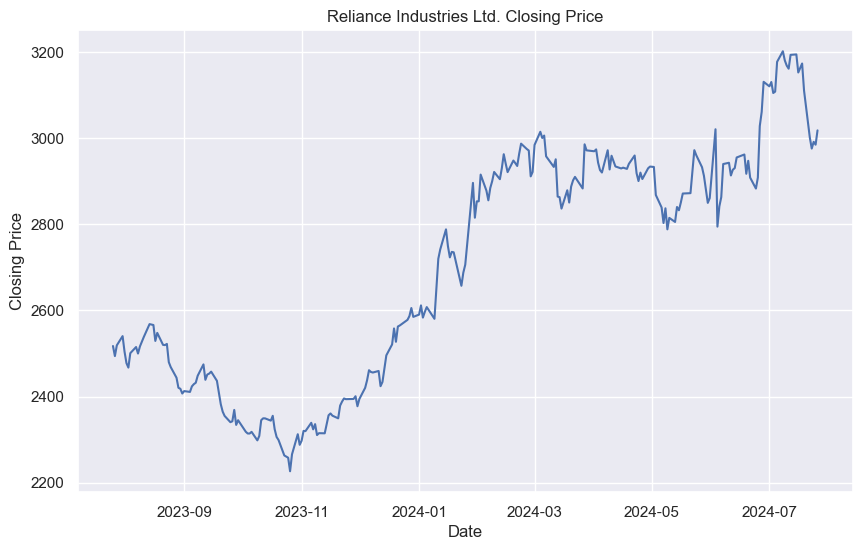

In [3]:
#importing reliance data from yfinance for one year



reliance = yf.Ticker("RELIANCE.NS")
reliance_data = reliance.history(period="1y")
reliance_data = reliance_data.dropna()
reliance_data['Date'] = reliance_data.index
reliance_data = reliance_data.reset_index(drop=True)

#plotting the closing price of reliance using seaborn

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=reliance_data['Date'], y=reliance_data['Close'])
plt.title('Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()




In [4]:
#check for missing values
print(reliance_data.isnull().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Date            0
dtype: int64


In [5]:
#stationarity check
from statsmodels.tsa.stattools import adfuller
test_results = adfuller(reliance_data['Close'])
print('ADF Statistic: %f' % test_results[0])    
print('p-value: %f' % test_results[1])
print('Critical Values:')
for key, value in test_results[4].items():
    print('\t%s: %.3f' % (key, value))
if test_results[1] < 0.05:
	print('Reject the null hypothesis: The time series is stationary.')
else:
	print('Failed to reject the null hypothesis: The time series is non-stationary.')


ADF Statistic: -0.701125
p-value: 0.846458
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Failed to reject the null hypothesis: The time series is non-stationary.


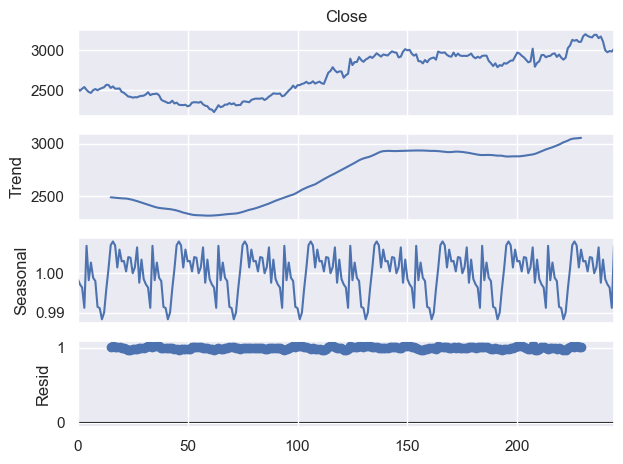

In [6]:
#seperating trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(reliance_data['Close'], model='multiplicative', period=30)
result.plot()
plt.show()


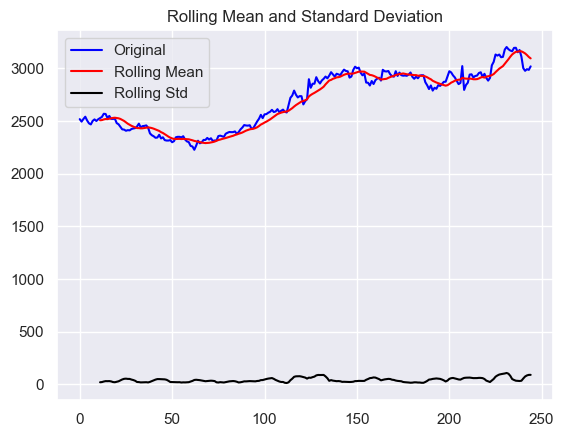

Results of dickey fuller test
Test Statistics                 -0.701125
p-value                          0.846458
No. of lags used                 1.000000
Number of observations used    243.000000
critical value (1%)             -3.457551
critical value (5%)             -2.873509
critical value (10%)            -2.573148
dtype: float64


In [7]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(reliance_data['Close'])

In [8]:
# Check for stationarity
test_results = adfuller(reliance_data['Close'])
if test_results[1] < 0.05:
    print('The time series is already stationary.')
else:
    # Difference the data
    differenced_data = reliance_data['Close'].diff().dropna()

    # Check for stationarity again
    test_results = adfuller(differenced_data)
    if test_results[1] < 0.05:
        print('After differencing, the time series is stationary.')
    else:
        print('Differencing alone did not achieve stationarity. Additional steps may be required.')

After differencing, the time series is stationary.


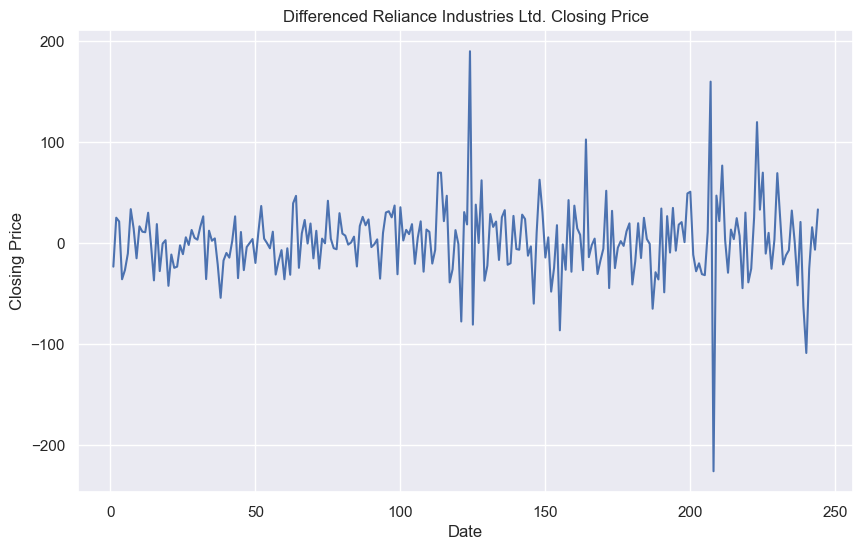

In [9]:
#plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(differenced_data)
plt.title('Differenced Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

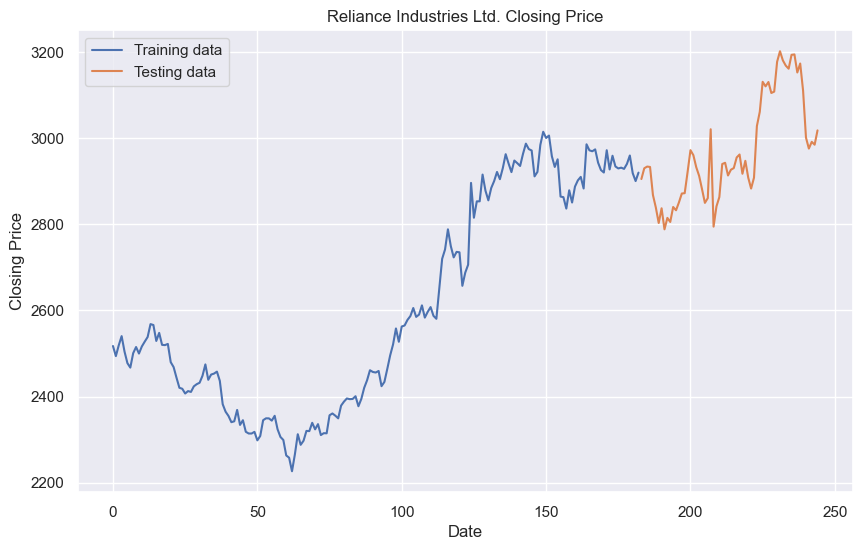

In [10]:
#splitting the data using train test split 75-25
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(reliance_data['Close'], train_size=0.75, shuffle=False)

#plotting the train and test data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training data')
plt.plot(test_data, label='Testing data')
plt.title('Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1769.406, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1767.941, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1768.226, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1768.336, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1769.530, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1767.249, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1769.249, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1769.249, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1769.935, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1770.834, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1766.351, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1767.463, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1767.165, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1768.347, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]          

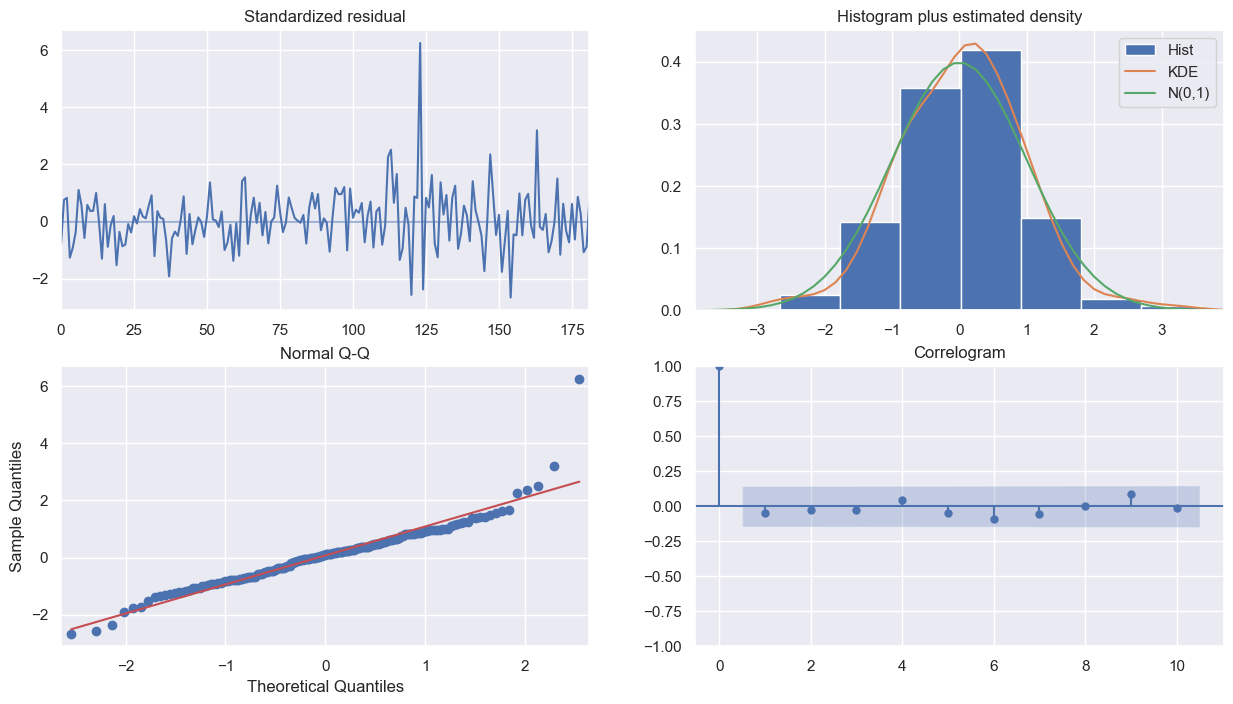

In [27]:
#applying autoarima model to the training data
from pmdarima.arima import auto_arima
smodel_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel_autoARIMA.summary())
smodel_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [23]:
#building model using sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

d:\MLDL Projects\Financial Modelling\Financial Modelling & Analysis\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  183
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -877.615
Date:                Fri, 26 Jul 2024   AIC                           1765.231
Time:                        23:02:59   BIC                           1781.251
Sample:                             0   HQIC                          1771.725
                                - 183                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9503      0.052    -37.214      0.000      -2.053      -1.848
ar.L2         -0.9891      0.050    -19.976      0.000      -1.086      -0.892
ma.L1          1.9235      0.080     24.155      0.0

d:\MLDL Projects\Financial Modelling\Financial Modelling & Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Forecast
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Reliance Industries Ltd. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

d:\MLDL Projects\Financial Modelling\Financial Modelling & Analysis\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ValueError: too many values to unpack (expected 3)

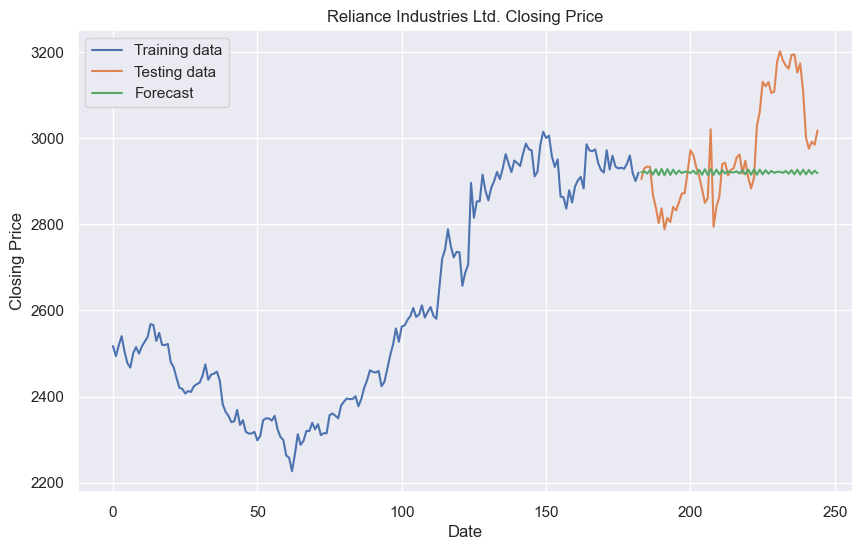

In [28]:
#Forecasting and prediction based on sarimax
forecast = model_fit.forecast(steps=len(test_data))
forecast = pd.Series(forecast, index=test_data.index)


#plotting the forecasted data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training data')
plt.plot(test_data, label='Testing data')
plt.plot(forecast, label='Forecast')
plt.title('Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


        Forecast  Lower Bound  Upper Bound
183  2920.776279  2863.080163  2978.472395
184  2923.016545  2842.509027  3003.524062
185  2917.830082  2818.657477  3017.002686
186  2925.729102  2811.836084  3039.622119
187  2915.454093  2787.652162  3043.256025
..           ...          ...          ...
240  2915.730651  2481.660342  3349.800959
241  2926.041819  2488.276428  3363.807211
242  2916.920850  2475.451525  3358.390175
243  2924.509912  2479.369954  3369.649871
244  2918.731194  2469.984543  3367.477845

[62 rows x 3 columns]


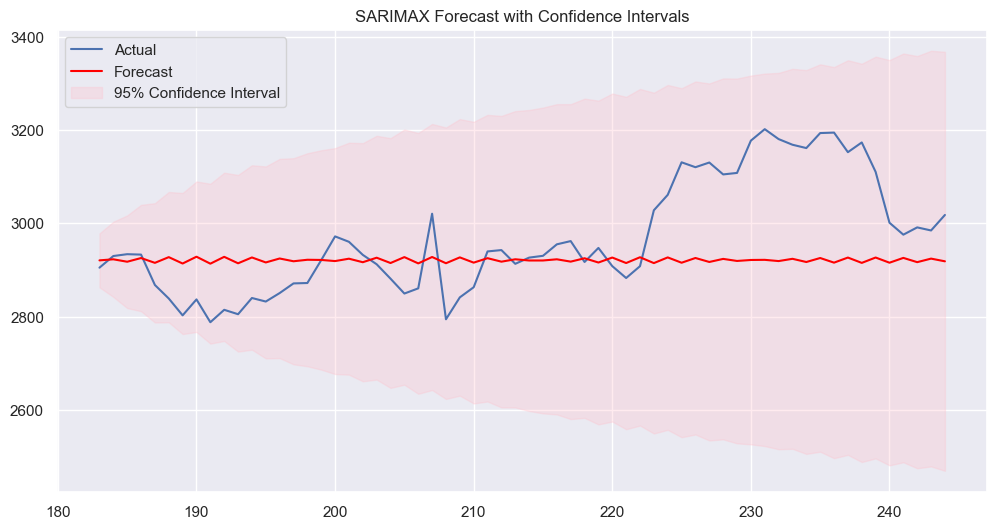

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have already fit your model and have your test data
# model = your fitted SARIMAX model
# test_data = your test dataset

# Get the number of periods in your test data
n_periods = len(test_data)

# Make the forecast
forecast = model_fit.get_forecast(steps=n_periods)

# Get the forecasted values
forecast_mean = forecast.predicted_mean

# Get the confidence intervals
confidence_intervals = forecast.conf_int()

# If you want 95% confidence interval
lower_bounds = confidence_intervals.iloc[:, 0]
upper_bounds = confidence_intervals.iloc[:, 1]

# Create a DataFrame with the results
results = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
})

# If your test_data is a Series with a DatetimeIndex, use:
# results.index = test_data.index
# Otherwise, if it's just a range of dates, you might need to set the index manually

# Print the results
print(results)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(results.index, results['Forecast'], color='red', label='Forecast')
plt.fill_between(results.index, 
                 results['Lower Bound'], 
                 results['Upper Bound'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title('SARIMAX Forecast with Confidence Intervals')
plt.show()

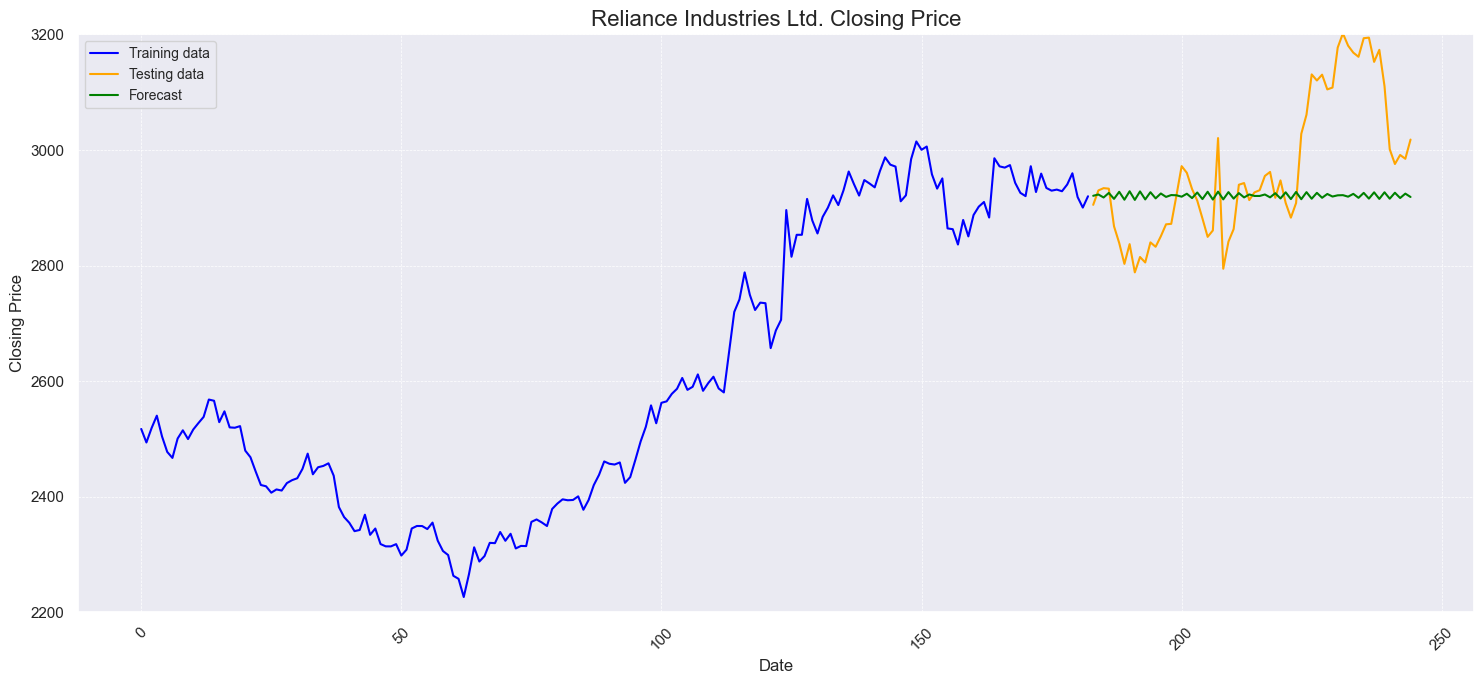

In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have your data split into train_data and test_data
# and you've already fit your SARIMAX model

# Make the forecast
forecast = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

# Create the plot
plt.figure(figsize=(15, 7))

# Plot training data
plt.plot(train_data.index, train_data, label='Training data', color='blue')

# Plot testing data
plt.plot(test_data.index, test_data, label='Testing data', color='orange')

# Plot forecast
plt.plot(test_data.index, forecast_mean, label='Forecast', color='green')

# Customize the plot
plt.title('Reliance Industries Ltd. Closing Price', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set y-axis limits similar to your image
plt.ylim(2200, 3200)

# Improve x-axis readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

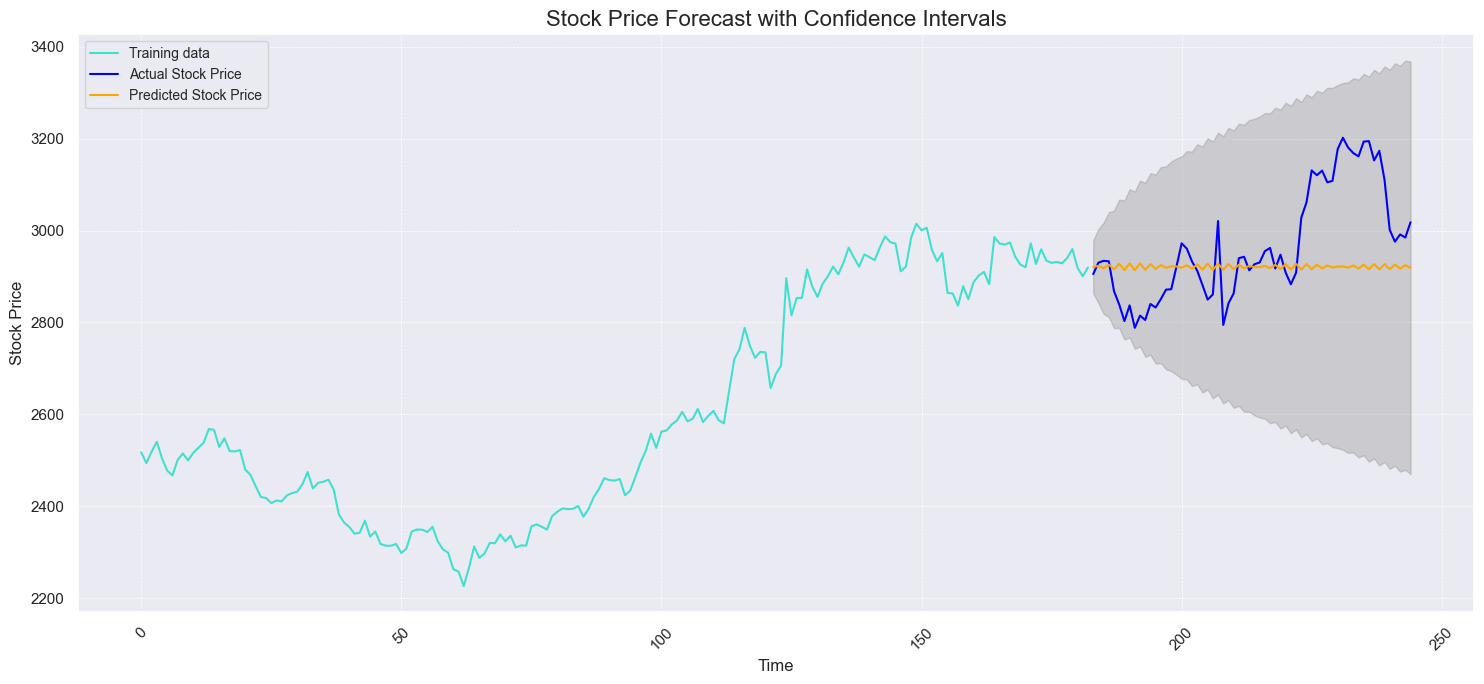

In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have your data split into train_data and test_data
# and you've already fit your SARIMAX model

# Make the forecast
forecast = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create the plot
plt.figure(figsize=(15, 7))

# Plot training data
plt.plot(train_data.index, train_data, label='Training data', color='turquoise')

# Plot actual stock price (test data)
plt.plot(test_data.index, test_data, label='Actual Stock Price', color='blue')

# Plot predicted stock price
plt.plot(test_data.index, forecast_mean, label='Predicted Stock Price', color='orange')

# Plot confidence intervals
plt.fill_between(test_data.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='gray', alpha=0.3)

# Customize the plot
plt.title('Stock Price Forecast with Confidence Intervals', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve x-axis readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have your data and your SARIMAX model is already fit
# data = your full dataset
# model = your fitted SARIMAX model

# Determine the number of days to forecast (approximately 1 month)
forecast_days = 30  # Adjust this if you want a different number of days

# Generate future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

# Make the forecast
forecast = model.get_forecast(steps=forecast_days)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create the plot
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(data.index, data, label='Historical Stock Price', color='blue')

# Plot forecasted values
plt.plot(future_dates, forecast_mean, label='Forecasted Stock Price', color='red')

# Plot confidence intervals
plt.fill_between(future_dates, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

# Customize the plot
plt.title('1-Month SARIMAX Forecast with Confidence Intervals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve x-axis readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Print the forecasted values
print(forecast_mean)

NameError: name 'data' is not defined

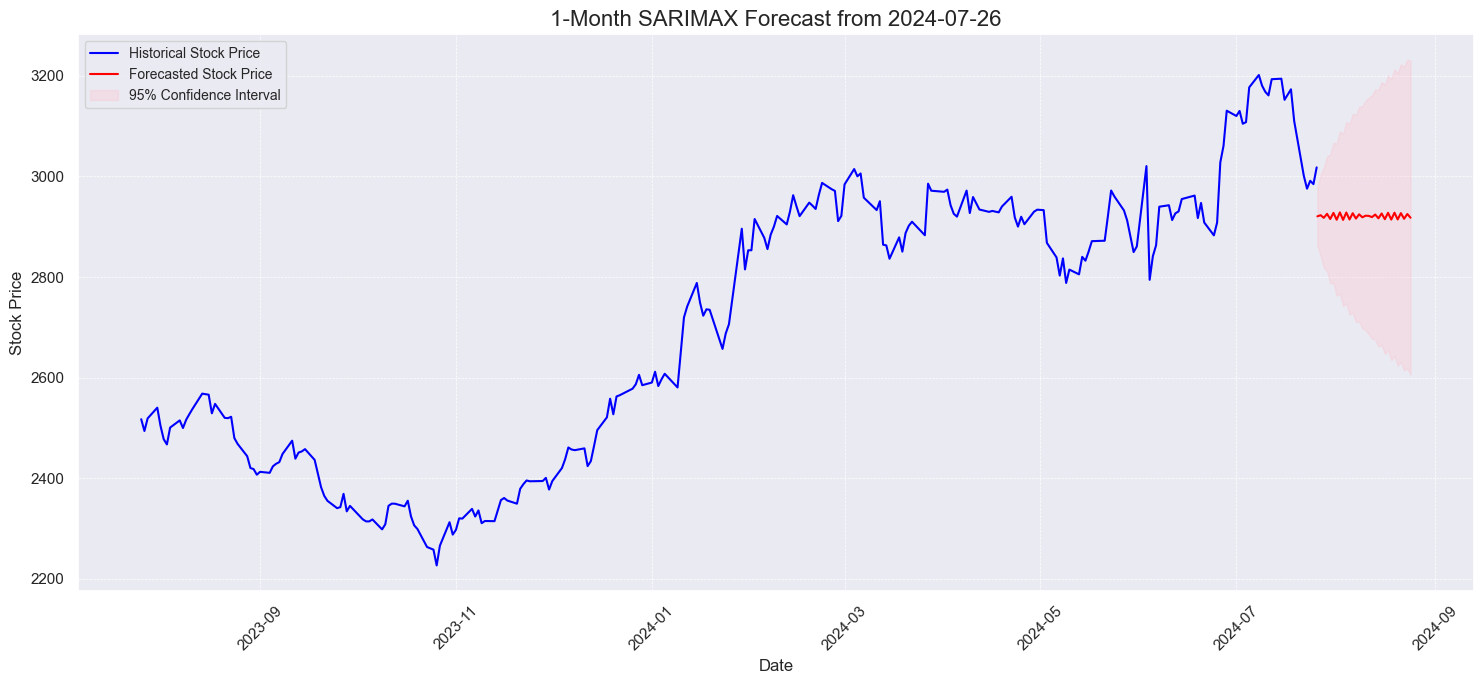

2024-07-26    2920.776279
2024-07-27    2923.016545
2024-07-28    2917.830082
2024-07-29    2925.729102
2024-07-30    2915.454093
2024-07-31    2927.679795
2024-08-01    2913.999922
2024-08-02    2928.586296
2024-08-03    2913.670391
2024-08-04    2928.332309
2024-08-05    2914.491686
2024-08-06    2926.981797
2024-08-07    2916.313160
2024-08-08    2924.765295
2024-08-09    2918.834223
2024-08-10    2922.040999
2024-08-11    2921.653623
2024-08-12    2919.237146
2024-08-13    2924.333081
2024-08-14    2916.784913
2024-08-15    2926.465213
2024-08-16    2915.052305
2024-08-17    2927.735268
2024-08-18    2914.289161
2024-08-19    2927.967333
2024-08-20    2914.591432
2024-08-21    2927.148279
2024-08-22    2915.889813
2024-08-23    2925.426258
2024-08-24    2917.963922
Freq: D, Name: predicted_mean, dtype: float64


In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Assuming you have your data and your SARIMAX model is already fit
# data = your full dataset
# model = your fitted SARIMAX model

# Set the forecast start date to today
today = datetime.now().date()

# Determine the number of days to forecast (approximately 1 month)
forecast_days = 30  # Adjust this if you want a different number of days

# Generate future dates starting from today
future_dates = pd.date_range(start=today, periods=forecast_days)

# Make the forecast
forecast = model_fit.get_forecast(steps=forecast_days)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Assign the future dates to the forecast results
forecast_mean.index = future_dates
confidence_intervals.index = future_dates

# Create the plot
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(reliance_data['Date'], reliance_data['Close'], label='Historical Stock Price', color='blue')

# Plot forecasted values
plt.plot(future_dates, forecast_mean, label='Forecasted Stock Price', color='red')

# Plot confidence intervals
plt.fill_between(future_dates, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

# Customize the plot
plt.title(f'1-Month SARIMAX Forecast from {today}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve x-axis readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Print the forecasted values
print(forecast_mean)